In [1]:
import os 
import sys 
from contextlib import contextmanager
from time import time

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgbm

In [2]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    """時間を測るやつ"""
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [3]:
INPUT_DIR = '/Users/mei/Documents/skill_up/kickstarter/input'
OUTPUT_DIR = '/Users/mei/Documents/skill_up/kickstarter/output'

# df_2016 = pd.read_csv(os.path.join(INPUT_DIR,'ks-projects-201612.csv'))
df_2018 = pd.read_csv(os.path.join(INPUT_DIR,'ks-projects-201801.csv'))

TARGET = 'state'
y = df_2018[TARGET]
del df_2018[TARGET]
X = df_2018.copy() 

# 訓練データ，テストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)

train_df = pd.concat([train_X,train_y],axis=1).reset_index(drop=True)
test_df = pd.concat([test_X,test_y],axis=1).reset_index(drop=True)
whole_df = pd.concat([train_df,test_df]).reset_index(drop=True)

In [4]:
def mapping(x):
    if x == 'failed':
        return 0
    elif x == 'canceled':
        return 1
    elif x == 'successful':
        return 2
    elif x=='live':
        return 3
    elif x=='undefined':
        return 4
    elif x=='suspended':
        return 5
    else:
        raise Exception
def encode_label(train_y, test_y):
    # 正解ラベルをエンコーディングしていく
    n_train = len(train_y)
    df = pd.concat([train_y,test_y]).reset_index(drop=True)
    
    df = df.apply(lambda x:mapping(x))


    test_y = df.iloc[n_train:].reset_index(drop=True)
    train_y = df.iloc[:n_train].reset_index(drop=True)

    return train_y,test_y

train_y,test_y = encode_label(train_y.copy(),test_y.copy())


In [5]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()
    
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)


# 前処理

In [6]:
# log1p変換を事前に行う

cols = ['goal','backers','pledged','usd_pledged_real','usd_goal_real']

for c in cols:
    train_df[c] = train_df[c].apply(lambda x: np.log1p(x))
    test_df[c] = test_df[c].apply(lambda x: np.log1p(x))


# 特徴量エンジニアリング

In [7]:
# def preprocess(input_df: pd.DataFrame)->pd.DataFrame:
#     output_df = pd.DataFrame()
#     cols = input_df.columns
#     for c in cols:
#         output_df[c] = input_df[c].apply(lambda x: np.log1p(x))
#     return output_df

# def create_continuous_feature(input_df:pd.DataFrame)->pd.DataFrame:
#     use_cols = ['goal','backers','pledged','usd_pledged_real','usd_goal_real']
#     output_df = preprocess(input_df[use_cols])
#     return output_df

def create_continuous_feature(input_df:pd.DataFrame)->pd.DataFrame:
    use_cols = ['goal','backers','pledged','usd_pledged_real','usd_goal_real']
    return input_df[use_cols].copy()

In [20]:
class CountEncoding(BaseBlock):
    #　カウントエンコーディングでカテゴリ変数を変換する
    def __init__(self,col,whole_df:pd.DataFrame):
        self.col = col
        self.whole_df = whole_df
    def transform(self, input_df:pd.DataFrame)-> pd.DataFrame:
        output_df = pd.DataFrame()
        c = self.col

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE=')

class AggregationBlock(BaseBlock):
    # カテゴリ変数でグループ化した後集計する
    def __init__(self,group_col,target_col,whole_df:pd.DataFrame)-> pd.DataFrame:
        self.group_col = group_col
        self.target_col = target_col
        self.whole_df = whole_df
    
    def transform(self,input_df:pd.DataFrame)->pd.DataFrame:
        output_df = pd.DataFrame()
        col_name = str(f'{self.group_col}_{self.target_col}')
        _agg = whole_df.groupby(self.group_col)[self.target_col].agg(['count','sum','mean','max','min']).reset_index()
        output_df = pd.merge(input_df[self.group_col],_agg,on=self.group_col,how='left').reset_index(drop=True).drop(columns=self.group_col).add_prefix(col_name)
        return output_df.add_prefix(f'AG=')

In [9]:
# テスト
assert len(Log1pBlock('goal').fit(train_df.copy())) == len(train_df)
assert len(CountEncoding('country',whole_df).fit(train_df.copy())) == len(train_df)
assert len(AggregationBlock('country','goal',whole_df)).fit(train_df.copy())==len(train_df)

NameError: name 'Log1pBlock' is not defined

In [21]:
from itertools import product

# パイプライン
process_block = [
    WrapperBlock(create_continuous_feature),
    *[CountEncoding(c,whole_df) for c in ['category','main_category','currency','country']],
    *[AggregationBlock(g,t,whole_df) for g,t in product(['category','main_category','currency','country'],['goal','pledged','backers','usd_pledged_real','usd_goal_real'])],
]
process_block

In [24]:
train_feat_df = to_feature(train_df.copy(),process_block,is_train=True)
test_feat_df = to_feature(test_df.copy(),process_block,is_train=False)

 12%|█▏        | 3/25 [00:00<00:01, 13.48it/s]create <__main__.WrapperBlock object at 0x11a38c9a0> 0.035[s]
create <__main__.CountEncoding object at 0x11a13f280> 0.081[s]
create <__main__.CountEncoding object at 0x11a13ff70> 0.094[s]
 16%|█▌        | 4/25 [00:00<00:02, 10.24it/s]create <__main__.CountEncoding object at 0x11a377b50> 0.138[s]
create <__main__.CountEncoding object at 0x11a3775b0> 0.078[s]
 24%|██▍       | 6/25 [00:00<00:02,  9.07it/s]create <__main__.AggregationBlock object at 0x11a13f6a0> 0.154[s]
create <__main__.AggregationBlock object at 0x11a377e50> 0.114[s]
 32%|███▏      | 8/25 [00:01<00:03,  5.66it/s]create <__main__.AggregationBlock object at 0x11a377eb0> 0.173[s]
create <__main__.AggregationBlock object at 0x11a377130> 0.108[s]
 48%|████▊     | 12/25 [00:02<00:03,  3.94it/s]create <__main__.AggregationBlock object at 0x11a377af0> 0.113[s]
create <__main__.AggregationBlock object at 0x11a377dc0> 0.247[s]
 12%|█▏        | 3/25 [00:00<00:01, 21.43it/s]create <__mai

In [12]:
train_feat_df.head().T

,0,1,2,3,4
goal,7.313887e+00,9.210440e+00,7.601402e+00,1.046313e+01,7.824446e+00
backers,3.433987e+00,0.000000e+00,6.410175e+00,0.000000e+00,4.553877e+00
pledged,7.887584e+00,0.000000e+00,9.899605e+00,0.000000e+00,8.146419e+00
usd_pledged_real,7.887584e+00,0.000000e+00,9.899605e+00,0.000000e+00,7.860359e+00
usd_goal_real,7.313887e+00,9.210440e+00,7.601402e+00,1.092780e+01,7.538420e+00
...,...,...,...,...,...
AG=country_usd_pledged_realmin,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
AG=country_usd_goal_realsum,1.288582e+10,1.288582e+10,1.288582e+10,1.440290e+09,6.552910e+08
AG=country_usd_goal_realmean,4.403497e+04,4.403497e+04,4.403497e+04,4.277412e+04,4.440844e+04
AG=country_usd_goal_realmax,1.000000e+08,1.000000e+08,1.000000e+08,1.663614e+08,8.262414e+07


In [25]:
def fit_lgbm(X,y,cv,params=None,verbose=50):
    ## lgbmの学習を行う
    if params is None:
        params = {}
    
    n_classes = len(np.unique(y))
    oof = np.zeros(shape=(len(y),n_classes),dtype=np.float)
    models = []

    for i, (idx_train, idx_valid) in enumerate(cv): 
        X_tr, y_tr = X[idx_train], y[idx_train]
        X_val, y_val = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        clf.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=verbose)
        pred_i = clf.predict_proba(X_val)
        oof[idx_valid] = pred_i
        models.append(clf)

        return oof, models


In [26]:
params = {
    'n_estimators':1000,
    'learning_rate':.1,
    'reg_lambda': .1,
    'colsample_bytree': .5,
    'max_depth': 3,
    'min_child_weight': 10,
    'importance_type': 'gain'
}

In [27]:
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv = list(fold.split(train_feat_df,train_y))
oof, models = fit_lgbm(train_feat_df.values,train_y.values,cv,verbose=10)

Training until validation scores don't improve for 100 rounds
[10]	valid_0's multi_logloss: 0.483118
[20]	valid_0's multi_logloss: 0.394171
[30]	valid_0's multi_logloss: 0.368548
[40]	valid_0's multi_logloss: 0.35838
[50]	valid_0's multi_logloss: 0.354151
[60]	valid_0's multi_logloss: 0.352361
[70]	valid_0's multi_logloss: 0.350847
[80]	valid_0's multi_logloss: 0.351476
[90]	valid_0's multi_logloss: 0.351203
[100]	valid_0's multi_logloss: 0.351133
Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.350776


In [29]:
print('train accuracy(oof):')
print(accuracy_score(train_y.values, np.argmax(oof,axis=1)))

y_pred = [model.predict_proba(train_feat_df.values) for model in models]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred,axis=0)
y_pred = np.argmax(y_pred,axis=1)
print('train accuracy:')
print(accuracy_score(train_y.values,y_pred))

train accuracy(oof):
0.5944646912797761
train accuracy:
0.8844378862303914


In [31]:
def visualize_importance(models, feat_train_df):
    # 重要特徴量の可視化
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    fig.tight_layout()
    ax.grid()
    return fig, ax

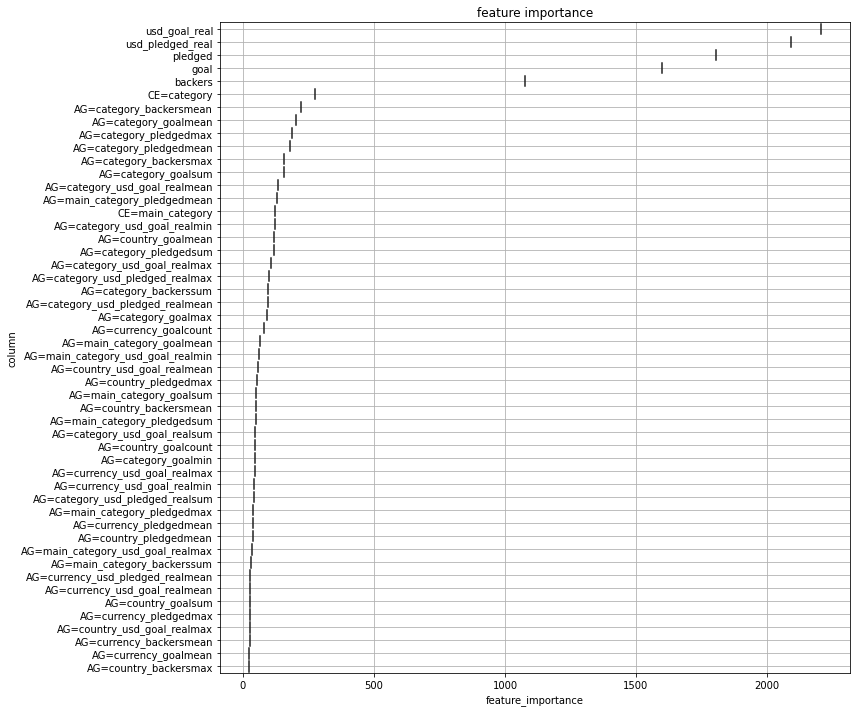

In [32]:
fig, ax = visualize_importance(models, train_feat_df)
ax.set_title('feature importance')
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'importance.png'), dpi=120)

In [33]:
y_pred = [model.predict_proba(test_feat_df.values) for model in models]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred,axis=0)
y_pred = np.argmax(y_pred,axis=1)
print('test accuracy:')
print(accuracy_score(test_y.values, y_pred))

test accuracy:
0.8824026514201206


## 結果

- データセットを8:2で訓練データとテストデータに分ける
- 訓練データを5分割の交差検証を行い学習していく．
- 5つのモデルの出力の平均から他クラス分類を行なった．

||accuracy|
|---|---|
|train|0.884|
|test|0.882|

今回作成したモデルでは，accuracy 0.88程度のモデルが作成できた．